In [16]:
import pyprob
%matplotlib inline
import matplotlib.pyplot as plt
from pyprob import Model
import numpy as np

In [187]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform
import torch
class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name="Gaussian with unknown mean") # give the model a name

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        a = pyprob.sample(Uniform(0,1), name = 'input1') # NOTE: sample -> denotes latent variables
        b = pyprob.sample(Uniform(0,1.5), name = 'input2') # NOTE: sample -> denotes latent variables

        a_visible = pyprob.sample(pyprob.distributions.Categorical([0.5,0.5]))
        b_visible = pyprob.sample(pyprob.distributions.Categorical([0.5,0.5]))
        
        total_energy = a + b
        visible_energy = 0
        if a_visible == 1:
            visible_energy += a
        if b_visible == 1:
            visible_energy += b
        
        true_missing_energy = total_energy - visible_energy
        missing_energy = pyprob.sample(pyprob.distributions.Normal(true_missing_energy, 0.05))
        
        probs = [0,1] if missing_energy > 1.2 else [1,0]
        obs_distr = pyprob.distributions.Categorical(probs)

        pyprob.observe(obs_distr, name='obs0') # NOTE: observe -> denotes observable variables
        return a,b, a_visible, b_visible, missing_energy, true_missing_energy

model = GaussianUnknownMean()

In [188]:
model.learn_inference_network(
    num_traces=10000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: 16__forward__a__Uniform__1, distribution: Uniform
New layers, address: 36__forward__b__Uniform__1, distribution: Uniform
New layers, address: 58__forward__a_visible__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 80__forward__b_visible__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 152__forward__missing_energy__Normal__1, distribution: Normal
Total addresses: 5, parameters: 10,103
0d:00:00:13 | 1    | 10,048    | +1.87e-01 | -2.16e-01 | -5.38e-02 | 0d:00:00:00 | 762.0                              


In [189]:
condition  = {'obs0': 1}

prior = model.prior_distribution(
    num_traces=2000,
)
posterior = model.posterior_distribution(
    num_traces=2000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe=condition
)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 2000/2000 | 1,058.09       
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:27 | 0d:00:00:00 | #################### | 2000/2000 | 73.60       


In [190]:
edges = np.linspace(-10,10, 25)

In [191]:
prior     = np.asarray([[x.item() for x in prior.sample()] for x in range(1000)])
posterior = np.asarray([[x.item() for x in posterior.sample()] for x in range(1000)])

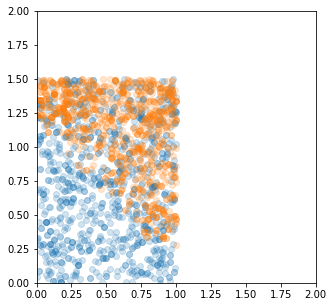

In [192]:
plt.scatter(prior[:,0],prior[:,1], alpha = 0.2)
plt.scatter(posterior[:,0],posterior[:,1], alpha = 0.2)
plt.xlim(0,2)
plt.ylim(0,2)
plt.gcf().set_size_inches(5,5)

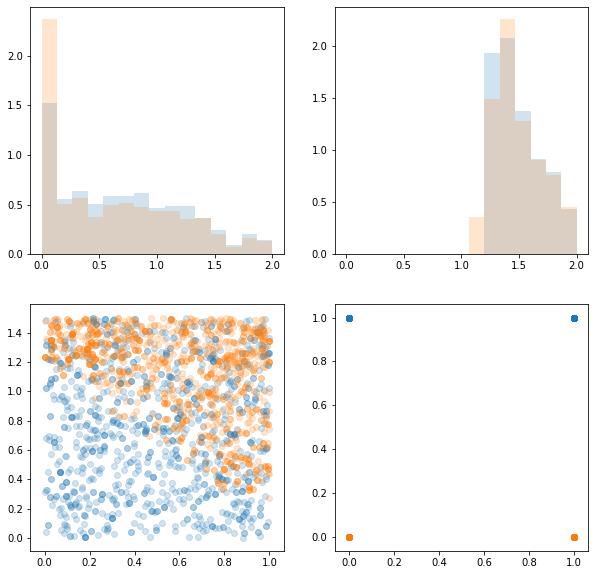

In [193]:
f, axarr = plt.subplots(2,2)
f.set_size_inches(10,10)
edges = np.linspace(0,2,16)
axarr[0,0].hist(prior[:,4], bins = edges, density = True, alpha = 0.2)
axarr[0,1].hist(posterior[:,4], bins = edges, density = True, alpha = 0.2)
axarr[0,0].hist(prior[:,5], bins = edges, density = True, alpha = 0.2)
axarr[0,1].hist(posterior[:,5], bins = edges, density = True, alpha = 0.2)

axarr[1,0].scatter(prior[:,0],prior[:,1], alpha = 0.2)
axarr[1,0].scatter(posterior[:,0],posterior[:,1], alpha = 0.2)


axarr[1,1].scatter(prior[:,2],prior[:,3], alpha = 0.2)
axarr[1,1].scatter(posterior[:,2],posterior[:,3], alpha = 0.2)

(array([721.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 279.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

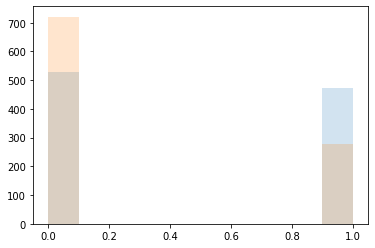

In [195]:
plt.hist(prior[:,2], alpha = 0.2)
plt.hist(posterior[:,2], alpha = 0.2)

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

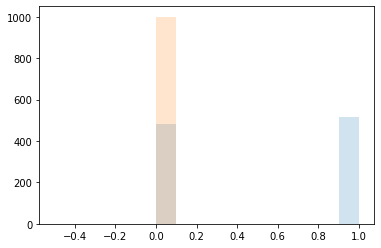

In [196]:
plt.hist(prior[:,3], alpha = 0.2)
plt.hist(posterior[:,3], alpha = 0.2)